In [ ]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

In [ ]:
# Parametros del sistema
N = 1024 # longitud del código
K = 512 # número de bits de información (antes de CRC)
coderate = K/N # tasa del código
bitsxsimb = 4 # bits por símbolo (QAM16)
EBNO_DB_MIN = 0
EBNO_DB_MAX = 15
LOTE = 100 # tamaño del lote

In [ ]:
# Generador 'dummy' de bits congelados
# import csv

congelados_aleatorios = np.random.permutation(N)[:(N-K)]
# with open('random_digits.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(digits)
# congelados_aleatorios = np.loadtxt('random_digits.csv', delimiter=',', dtype=int)

In [5]:
# Generador Monte Carlo de bits congelados

simulaciones = 500 # Reduced number of simulations to avoid OOM
snr_prueba = 2.0
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=coderate)

# Simulacion Monte Carlo
BER_bits = np.zeros(N)
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion)
awgn = sionna.phy.channel.AWGN()

for i in range(N):
    bits_congelados = np.array([j for j in range(N) if j != i])
    codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    # Consider reducing list_size further if OOM persists
    decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=1) # Reduced list_size

    # Se generan simulaciones sobre el canal AWGN
    bits = datos([simulaciones, 1])
    bits_codif = codificador(bits)
    x = mapeador(bits_codif)
    y = awgn(x, no)
    llr = demapeador(y, no)
    bits_decodif = decodificador(llr)

    errores = tf.not_equal(bits, bits_decodif)
    BER_bits[i] = tf.reduce_mean(tf.cast(errores, tf.float32))

# Resultados Monte Carlo
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[:(N-K)]
bits_congelados2 = indices_ordenados[-(N-K):]

In [ ]:
# Save bits_congelados to a CSV file
np.savetxt('monte_carlo_frozen_bits.csv', bits_congelados, delimiter=',', fmt='%d')

In [6]:
class CodPolarCanalAWGN(sionna.phy.Block):
    def __init__(self, N, K, bits_congelados, CRC_tipo="CRC24A", lista_SCL=8, bitsxsimb=4):
        super().__init__()
        self.N = N
        self.K = K
        self.K_datos = K - 24  # Asumiendo CRC24A
        self.bits_congelados = bits_congelados
        self.CRC_tipo = CRC_tipo
        self.lista_SCL = lista_SCL
        self.bitsxsimb = bitsxsimb

        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.CRC_codif = sionna.phy.fec.crc.CRCEncoder(CRC_tipo)
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.awgn = sionna.phy.channel.AWGN()
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=lista_SCL)
        self.CRC_decodif = sionna.phy.fec.crc.CRCDecoder(crc_encoder=self.CRC_codif)

    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.K_datos])
        data_con_crc = self.CRC_codif(b)
        bits_codif = self.polar_codif(data_con_crc)

        # Mapeo
        x = self.mapeador(bits_codif)

        # Canal AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=self.K/self.N)
        y = self.awgn(x, no)

        # Demapeo
        llr = self.demapeador(y, no)

        # Decodificación
        words_decodif = self.polar_decodif(llr)
        b_hat, crc_ok = self.CRC_decodif(words_decodif)

        return b, b_hat, llr, crc_ok

In [7]:
sistema = CodPolarCanalAWGN(N, K, bits_congelados2)

# @tf.function() # devuelve una versión acelerada
# def acelerado(batch_size, ebno_db):
#     return sistema(batch_size, ebno_db)

# b_hat, b, llr, crc_ok = sistema(LOTE, EBNO_DB_MAX)
# print(b.shape)  # debería ser (1, 488)
# print(b_hat.shape)  # debería ser (1, 488)
# print(crc_ok)  # debería ser True

/usr/local/lib/python3.12/dist-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.9403e-01 | 1.0000e+00 |      120544 |      244000 |          500 |         500 |        64.7 |reached target block errors
      1.0 | 4.8485e-01 | 1.0000e+00 |      118304 |      244000 |          500 |         500 |        63.3 |reached target block errors
      2.0 | 4.6882e-01 | 1.0000e+00 |      114393 |      244000 |          500 |         500 |        62.8 |reached target block errors
      3.0 | 4.2509e-01 | 9.9667e-01 |      124466 |      292800 |          598 |         600 |        76.3 |reached target block errors
      4.0 | 2.5515e-01 | 8.6333e-01 |       74707 |      292800 |          518 |         600 |        75.6 |reached target block errors
      5.0 | 8.6932e-02 | 7.2143e-01 |       29696 |      341600 |

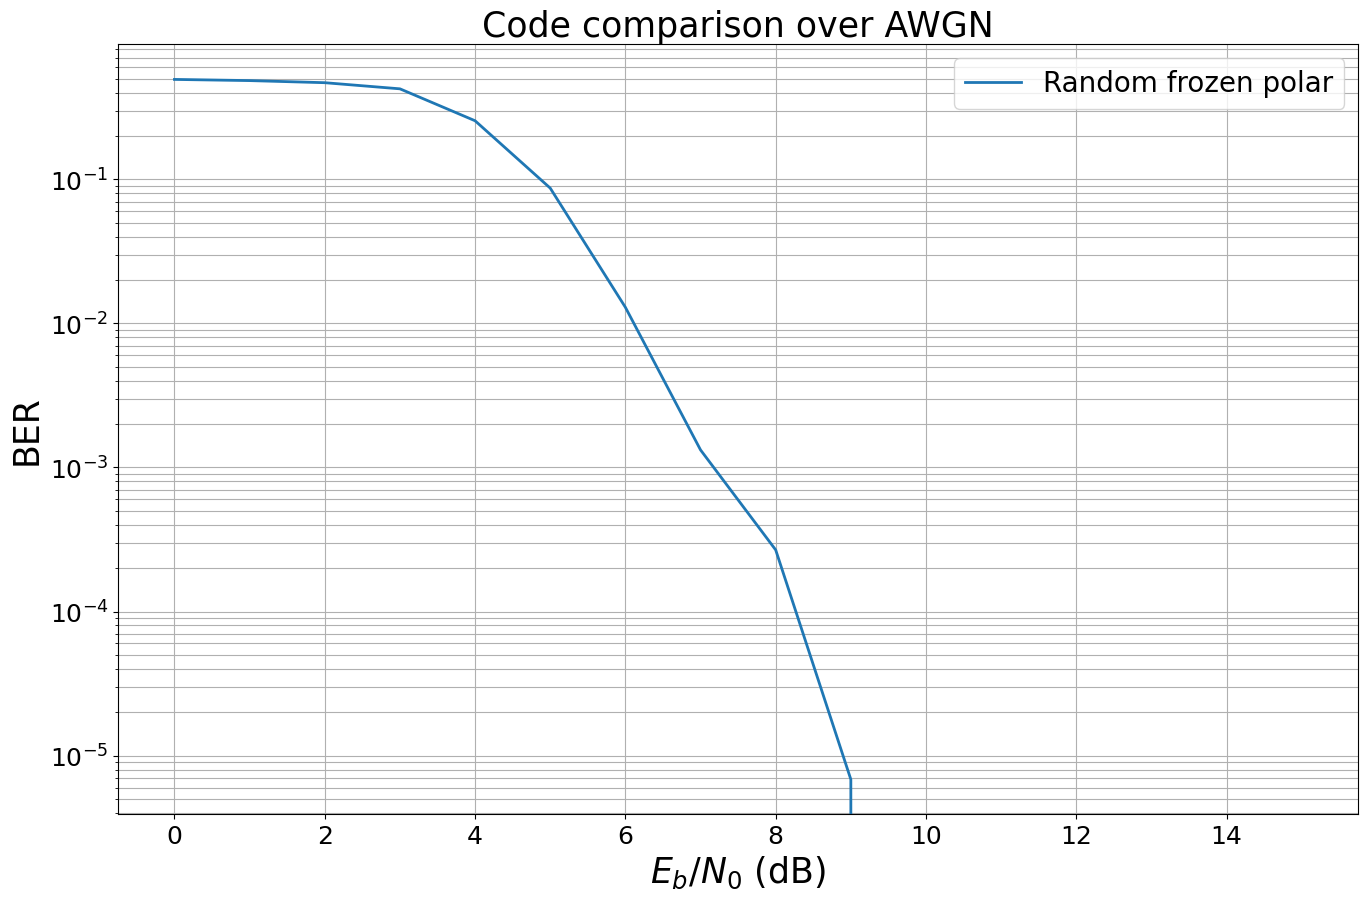

In [8]:
ber_plots = sionna.phy.utils.PlotBER("Code comparison over AWGN")
ber_plots.simulate(sistema,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=500,
                   legend="Random frozen polar",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False);